# Case study: Optimization for volumetric productivity in a fed batch setup (Gotsmy2023)

Paper: Sulfate limitation increases specific plasmid DNA yield and productivity in *E. coli* fed-batch processes (Gotsmy *et al.* 2023)

Doi: https://doi.org/10.1186/s12934-023-02248-2 

In the following code a fed batch optimization of plasmid DNA is conducted and aims to reproduce the results of the above mentioned paper. Only the 2. and 3. stage of the paper are used since the first stage is a batch process.

The submodels here were implemented in a way that they are independent of sulfate, such that the switch occurs just based on the optimal volumetric productivity, which is dependent on the switching time that is tested out (because in the original paper the switch occurred when sulfate = 0). You can calculate the intial sulfate based on our solution (see below).

In [8]:
### Import packages
import polars as pl
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display

# For storing DataFrames
import pickle

# Get OptMSP
import sys
from os import getcwd
sys.path.append(getcwd())
import MultiStagePackage.OptMSPfunctions as msp

# For optimization
from pygmo import *

### Models

In [40]:
# Initial values
G_0 = 0         # Glucose (substrate)
V_0 = 0.5       # Volume
X_0 = 3.04      # Biomass
P_0 = 0         # Product (plasmid DNA)
S_0 = 3.8       # Sulfate
s_ini= [G_0, V_0, X_0, P_0, S_0]

#  Indexing              
G, V, X, P, S = (i for i in range(5))    

In [3]:
## Numeric ODE models:
# y  = start values for biomass, substrate, product [numpy array]
def growth_phase(t, y):
    # Measurement-based parameters: 
    C_G = 330
    r_F = 0.0139 #l/h
    pi_mu = 0.0049 # g/g*h       4.9
    Y_PG = 0.847
    Y_SX = 0.024
    Y_XG = 0.487
    ATPM = 6.86
    ATPM_gammaM = 23.5 / 0.180156

    gamma_M = ATPM/ ATPM_gammaM
    gamma_P = pi_mu / Y_PG

    # Check for values smaller 0
    for i in range(len(y)):
        if(y[i]<0.0):
            y[i] = 0.0

    gamma = (r_F * (C_G/y[V]))/y[X]
    gamma_X = gamma - gamma_M - gamma_P
    mu = gamma_X * Y_XG
    dGdt = 0
    dVdt = r_F
    dXdt = mu * y[X] - (r_F/y[V])*y[X]
    dPdt = pi_mu * y[X] - (r_F/y[V])*y[P]
    dSdt = -mu * y[X] * Y_SX - (r_F /y[V]) * y[S]
    
    dydt = [dGdt, dVdt, dXdt, dPdt, dSdt]
    return(dydt)

def starvation_phase(t, y):
    # Measurement-based parameters: 
    kappa=2
    pi_star = 0.0049 * kappa # g/g*h
    r_F = 0.0139 #l/h

    # Check for values smaller 0
    for i in range(len(y)):
        if(y[i]<0.0):
            y[i] = 0.0

    dGdt = 0
    dVdt = r_F
    dXdt = - (r_F/y[V])*y[X]
    dPdt = pi_star * y[X] - (r_F/y[V])*y[P]
    dSdt = 0

    dydt = [dGdt, dVdt, dXdt, dPdt, dSdt]
    return(dydt)

In [4]:
models = [growth_phase, starvation_phase]

### Brute Force Approach

In [5]:
def event_bio0(t,y):
    if(y[X] <= 0.001):
        return 0    # 0 that event triggers
    return 1

In [6]:
%%time
# Set parameters
t_start = 0
t_end = 36
min_duration = 0
n_stages = 2
den = 100

BruteForceNum_2Stage_36h = msp.do_brute_force_num(  combis=[(0,1)],             # We want only one combination of modules (First growth and then production phase)
                                                    models=models,              # The functions of the models 
                                                    n_stages=n_stages,          # The maximum stages the user wants to test out (optimal solution might turn out to not have as many stages)
                                                    t_start=t_start,            # start time of process
                                                    t_end=t_end,                # end time of process
                                                    min_duration=min_duration,  # minimal duration of each sub-process/module
                                                    s=s_ini,                    # initial values of species
                                                    events=[event_bio0],        # event function for denoting real end time of fermentation (here when no biomass is present anymore; in other use cases different)
                                                    density=den,                # density or step time (how frequent the switching times are sampled -> see for more information OptMSP_SupportFunctions.ipynb notebook)
                                                    indexes=[X,G,P],            # indexes to denote at which position in the model are biomass, substrate and product (default is [0,1,2]; -> see for more information ModelingTutorial.ipynb notebook)
                                                    decimal=6)                  # decimal positions for rounding       
display(BruteForceNum_2Stage_36h)

/tmp/ipykernel_581024/344039148.py:47: RuntimeWarning: divide by zero encountered in scalar divide
  dXdt = - (r_F/y[V])*y[X]
/tmp/ipykernel_581024/344039148.py:47: RuntimeWarning: invalid value encountered in scalar multiply
  dXdt = - (r_F/y[V])*y[X]
/tmp/ipykernel_581024/344039148.py:48: RuntimeWarning: divide by zero encountered in scalar divide
  dPdt = pi_star * y[X] - (r_F/y[V])*y[P]
/tmp/ipykernel_581024/344039148.py:48: RuntimeWarning: invalid value encountered in scalar multiply
  dPdt = pi_star * y[X] - (r_F/y[V])*y[P]
/tmp/ipykernel_581024/344039148.py:47: RuntimeWarning: overflow encountered in scalar divide
  dXdt = - (r_F/y[V])*y[X]
/tmp/ipykernel_581024/344039148.py:48: RuntimeWarning: overflow encountered in scalar divide
  dPdt = pi_star * y[X] - (r_F/y[V])*y[P]
/home/jbauer/Documents/1_Projects/TwoStg/MultiStagePackage/OptMSPfunctions.py:431: RuntimeWarning: divide by zero encountered in scalar divide
  'Y_SubInput': [np.round((res[indexes[2]]/s[indexes[1]]), decimal

,Index,Times,Models,End_T,End_X,End_S,End_P,finished,Vol_P,Y_SubInput,Y_SubUsed
0,1,"(0.0, 0.0, 36.0)","[1, 2]",2.0,2.000000,2.0,2.000000,2.0,1.000000,inf,-1.0
1,2,"(0.0, 0.01, 36.0)","[1, 2]",36.0,1.541287,0.0,0.543690,inf,0.015102,inf,inf
2,3,"(0.0, 0.02, 36.0)","[1, 2]",36.0,1.563175,0.0,0.551333,inf,0.015315,inf,inf
3,4,"(0.0, 0.03, 36.0)","[1, 2]",36.0,1.585058,0.0,0.558971,inf,0.015527,inf,inf
4,5,"(0.0, 0.04, 36.0)","[1, 2]",36.0,1.606934,0.0,0.566603,inf,0.015739,inf,inf
...,...,...,...,...,...,...,...,...,...,...,...
3596,3597,"(0.0, 35.96, 36.0)","[1, 2]",36.0,50.834565,0.0,5.360109,inf,0.148892,inf,inf
3597,3598,"(0.0, 35.97, 36.0)","[1, 2]",36.0,50.842442,0.0,5.357621,inf,0.148823,inf,inf
3598,3599,"(0.0, 35.980000000000004, 36.0)","[1, 2]",36.0,50.850317,0.0,5.355131,inf,0.148754,inf,inf
3599,3600,"(0.0, 35.99, 36.0)","[1, 2]",36.0,50.858189,0.0,5.352640,inf,0.148684,inf,inf


CPU times: user 14min 31s, sys: 28.1 ms, total: 14min 31s
Wall time: 14min 32s


In [7]:
BruteForceNum_2Stage_36h_best = (BruteForceNum_2Stage_36h[1:-2].sort_values(["Vol_P"], ascending=[False]).dropna(axis=0)[:1])
display(BruteForceNum_2Stage_36h_best)

,Index,Times,Models,End_T,End_X,End_S,End_P,finished,Vol_P,Y_SubInput,Y_SubUsed
2100,2101,"(0.0, 21.0, 36.0)","[1, 2]",36.0,36.146213,0.0,7.42761,inf,0.206323,inf,inf


### Plotting

  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array and two offsets from the bottom left corner of the image
  alpha: scalar or None
  animated: bool
  backgroundcolor: color
  bbox: dict with properties for `.patches.FancyBboxPatch`
  clip_box: `.Bbox`
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  color or c: color
  figure: `.Figure`
  fontfamily or family: {FONTNAME, 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
  fontproperties or font or font_properties: `.font_manager.FontProperties` or `str` or `pathlib.Path`
  fontsize or size: float or {'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large'}
  fontstretch or stretch: {a numeric value in range 0-1000, 'ultra-condensed', 'extra-condensed', 'condensed', 'semi-condensed', 'normal', 'semi-expanded', 'expanded', 'extra-expanded', 'ultra-expanded'}
  fontstyle or style: {'normal', 'italic', 'oblique'}
  fontvariant or var

/home/jbauer/Documents/1_Projects/TwoStg/MultiStagePackage/OptMSPfunctions.py:1020: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  sns.lineplot(


  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array and two offsets from the bottom left corner of the image
  alpha: scalar or None
  animated: bool
  backgroundcolor: color
  bbox: dict with properties for `.patches.FancyBboxPatch`
  clip_box: `.Bbox`
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  color or c: color
  figure: `.Figure`
  fontfamily or family: {FONTNAME, 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
  fontproperties or font or font_properties: `.font_manager.FontProperties` or `str` or `pathlib.Path`
  fontsize or size: float or {'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large'}
  fontstretch or stretch: {a numeric value in range 0-1000, 'ultra-condensed', 'extra-condensed', 'condensed', 'semi-condensed', 'normal', 'semi-expanded', 'expanded', 'extra-expanded', 'ultra-expanded'}
  fontstyle or style: {'normal', 'italic', 'oblique'}
  fontvariant or var

<module 'matplotlib.pyplot' from '/home/jbauer/miniconda3/envs/twostage/lib/python3.8/site-packages/matplotlib/pyplot.py'>

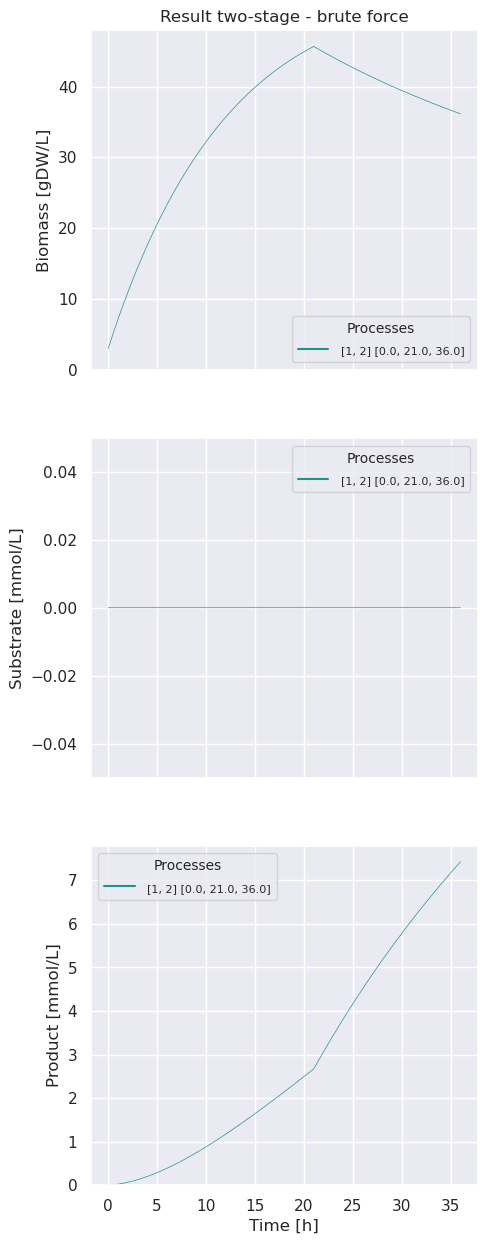

In [17]:
msp.do_custom_plot( df=BruteForceNum_2Stage_36h_best, 
                    models_num=models, 
                    s=s_ini, 
                    title="Result two-stage - brute force",
                    events=[event_bio0],
                    indexes=[X,G,P])

### Optimization Approach

In [7]:
def event_bio0(t,y):
    if(y[X] <= 0.001):
        return 0    # 0 that event triggers
    return 1

## 1.) Define objective (here volumetric productivity)
def volprod(simulation, indexes, initial_values, tstart, tend):
    # return simulation[indexes[2]]/(initial_values[indexes[1]]-simulation[indexes[1]])
    return simulation[P]/(simulation[-2]-tstart)

## 2.) Define the algorithm that will be used (in our case IHS) with the number of generations (fitness function evaluations) and a seed for reproducibility
# Note: per default there are always 10 evaluations so the total number of fitness function evaluations is 10 + the number of you pass to the gen attribute
algo_ihs = algorithm(ihs(gen=1000, seed=12345))  
algo_ihs.set_verbosity(100)  # output best performing each x-th generation

## 3.) Define optimization problem
# Defining the problem through creating a msp.Optimizer object
problem_sim_volP = problem(
    decorator_problem(
        msp.Optimizer(
            s=s_ini,                                # initial values of species
            models=models,                      # The functions of the models 
            indexes=[X,G,P],      # indexes to denote at which position in the model are biomass, substrate and product (default is [0,1,2]; -> see for more information ModelingTutorial.ipynb notebook)
            tstart=0,                           # start time of process
            tend=36,                            # end time of process
            max_stage=2,                        # The maximum stages the user wants to test out (optimal solution might turn out to not have as many stages)
            min_duration=1,                     # minimal duration of each sub-process/module
            events=[event_bio0],                # event function for denoting real end time of fermentation (here when no substrate is present anymore; in other use cases different)
            objective=volprod,                # Objective function (input as list!!)
            optmod="max",                       # Maximization or minimization? ("max" or "min")
        ),
        fitness_decorator=msp.f_log_decor,
    )
)
# Define a relative tolerance
problem_sim_volP.c_tol = 1e-3

## 4.) Starting the optimization
res_opt = algo_ihs.evolve(population(problem_sim_volP, size=10, seed=12345)) 


Fevals:          ppar:            bw:            dx:            df:      Violated:    Viol. Norm:        ideal1:
      1        0.35064       0.988553        14.1746       0.133725              0              0      -0.148615
    101        0.41464       0.312608       0.271426     0.00027422              0              0      -0.205607
    201        0.47864      0.0988553       0.530721    0.000189262              0              0      -0.206296
    301        0.54264      0.0312608       0.118595    2.27786e-05              0              0      -0.206304
    401        0.60664     0.00988553       0.191465    6.60582e-06              0              0      -0.206322
    501        0.67064     0.00312608      0.0440344    5.35633e-07              0              0      -0.206323
    601        0.73464    0.000988553       0.011329    2.07942e-08              0              0      -0.206323
    701        0.79864    0.000312608     0.00521053    9.88019e-09              0             

In [8]:
log_dataframe = pd.DataFrame(res_opt.problem.extract(decorator_problem).dv_log)[1:] 

best_res_opt = msp.do_opt_to_df(  df=log_dataframe,     # log dataframe from optimization
                                    n_best=1)               # Number of best performing processes that are returned

df=msp.do_convert(opt_res=best_res_opt,             # Output from do_opt_to_df()
                    models_num=models,                  # models (in numeric form)
                    t_start=0, 
                    t_end=36, 
                    s=s_ini, 
                    events=[event_bio0], 
                    indexes=[X,G,P])

No constraints found.


/home/jbauer/Documents/1_Projects/TwoStg/MultiStagePackage/OptMSPfunctions.py:630: RuntimeWarning: divide by zero encountered in scalar divide
  'Y_SubInput': [np.round((res[indexes[2]]/s[indexes[1]]), decimals=decimal)],
/home/jbauer/Documents/1_Projects/TwoStg/MultiStagePackage/OptMSPfunctions.py:631: RuntimeWarning: divide by zero encountered in scalar divide
  'Y_SubUsed' : [np.round((res[indexes[2]]/(s[indexes[1]]-res[indexes[1]])), decimals=decimal)]


Best result from optimization:

In [9]:
df

,Index,Times,Models,End_T,End_X,End_S,End_P,finished,Vol_P,Y_SubInput,Y_SubUsed
0,1,"[0.0, 21.003, 36.0]","[1, 2]",36.0,36.15,0.0,7.428,inf,0.206,inf,inf


##### Plotting

/home/jbauer/Documents/1_Projects/TwoStg/MultiStagePackage/OptMSPfunctions.py:1157: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  sns.lineplot(


<module 'matplotlib.pyplot' from '/home/jbauer/miniconda3/envs/twostage/lib/python3.8/site-packages/matplotlib/pyplot.py'>

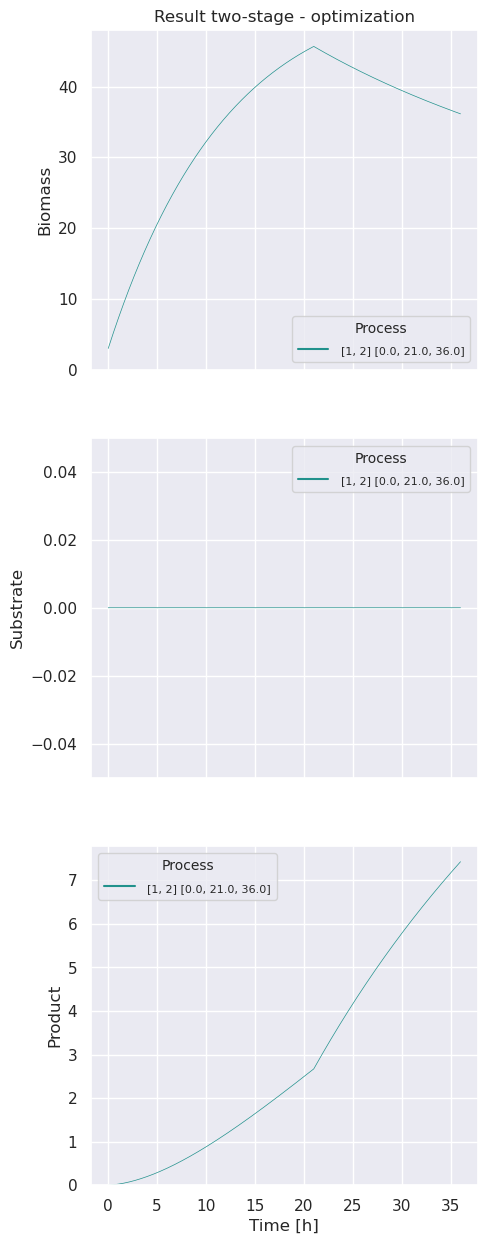

In [ ]:
msp.do_custom_plot(df, models, s_ini, "Result two-stage - optimization", [event_bio0], indexes=[X,G,P])

### Get the initial sulfate concentration

We have as optimal switching time now 21 h. So lets get the integration for that:

In [41]:
## Numeric ODE models:
# y  = start values for biomass, substrate, product [numpy array]
def growth_and_starvation_phase(t, y):
    # Measurement-based parameters: 
    C_G = 330
    r_F = 0.0139 #l/h
    pi_mu = 0.0049 # g/g*h
    Y_PG = 0.847
    Y_SX = 0.024
    Y_XG = 0.487
    ATPM = 6.86
    ATPM_gammaM = 23.5 / 0.180156
    kappa=2
    pi_star = 0.0049 * kappa # g/g*h
    r_F = 0.0139 #l/h

    gamma_M = ATPM/ ATPM_gammaM
    gamma_P = pi_mu / Y_PG

    # Check for values smaller 0
    for i in range(len(y)):
        if(y[i]<0.0):
            y[i] = 0.0

    if (t<21.00):
        gamma = (r_F * (C_G/y[V]))/y[X]
        gamma_X = gamma - gamma_M - gamma_P
        mu = gamma_X * Y_XG
        dGdt = 0
        dVdt = r_F
        dXdt = mu * y[X] - (r_F/y[V])*y[X]
        dPdt = pi_mu * y[X] - (r_F/y[V])*y[P]
        dSdt = -mu * y[X] * Y_SX - (r_F /y[V]) * y[S]
    else:
        dGdt = 0
        dVdt = r_F
        dXdt = - (r_F/y[V])*y[X]
        dPdt = pi_star * y[X] - (r_F/y[V])*y[P]
        dSdt = 0
    
    dydt = [dGdt, dVdt, dXdt, dPdt, dSdt]
    return(dydt)


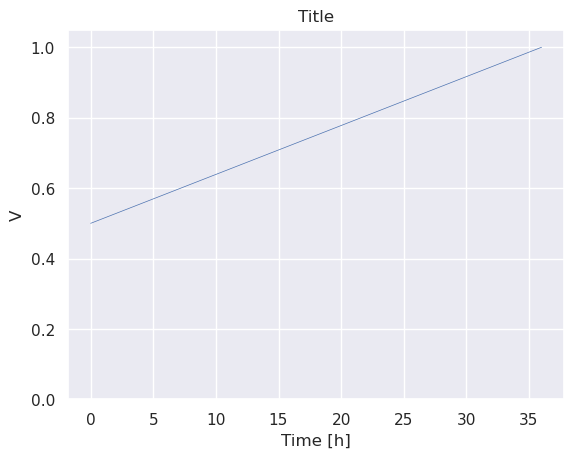

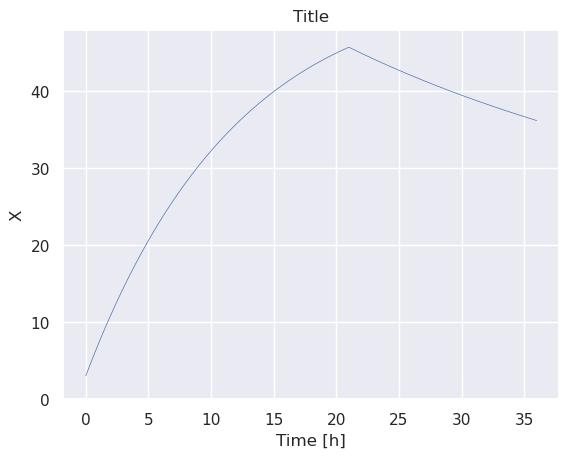

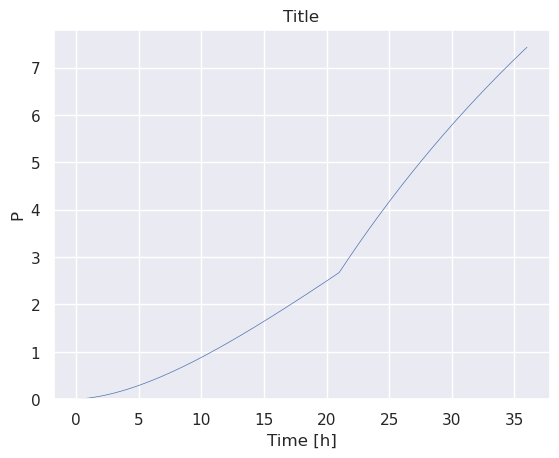

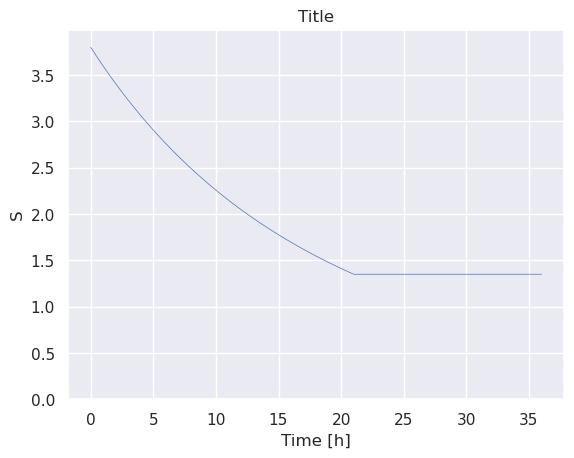

In [42]:
r = sp.integrate.solve_ivp(growth_and_starvation_phase, t_span=[0, 36], y0=s_ini, t_eval=[36], dense_output=True, max_step=0.005)
t = np.linspace(0, 36, (36+1)*50) # (times[1]+1)*20 = Resolution

dat= pd.DataFrame(data={    'Time [h]'  : t, 
                                'V'     : r.sol(t)[1],
                                'X'     : r.sol(t)[2],
                                'P'     : r.sol(t)[3],
                                'S'     : r.sol(t)[4]})

sns.lineplot(data=dat,x="Time [h]", y="V",linewidth=0.5,
).set(title="Title", ylim=(0, dat["V"].max()*1.05))
plt.show()

sns.lineplot(data=dat,x="Time [h]", y="X",linewidth=0.5,
).set(title="Title", ylim=(0, dat["X"].max()*1.05))
plt.show()

sns.lineplot(data=dat,x="Time [h]", y="P",linewidth=0.5,
).set(title="Title", ylim=(0, dat["P"].max()*1.05))
plt.show()

sns.lineplot(data=dat,x="Time [h]", y="S",linewidth=0.5,
).set(title="Title", ylim=(0, dat["S"].max()*1.05))
plt.show()

We set S=3.8 but as seen the complete sulfate was not used yet. We know that t switch should be at 21 h and we can reproduce the start concentration of sulfate from the paper in the way that we set it in the model and show that all substrate is consumed with our switch time:

Sulfate that was not used:   0.023542171709325065
Very low amount is left and therefore it supports the calculated the optimal switch time.


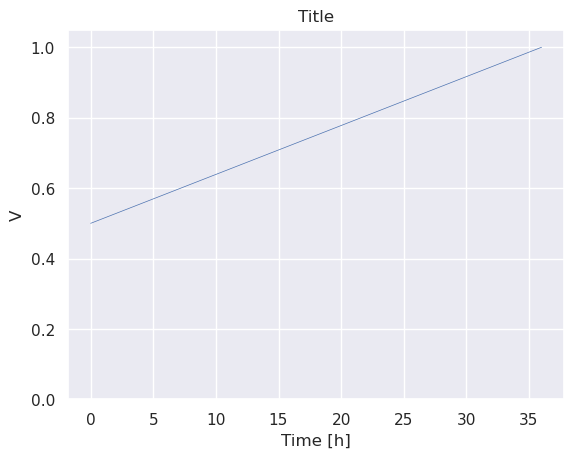

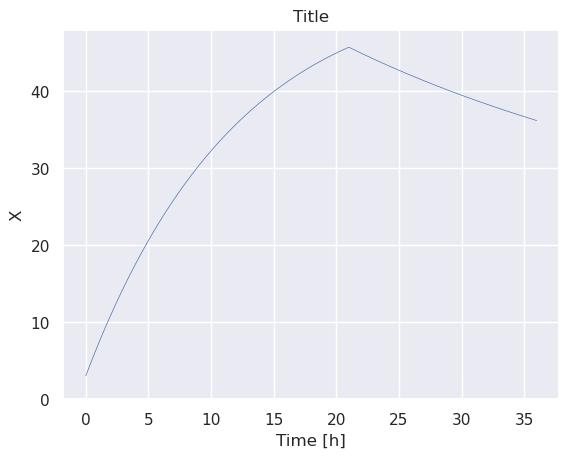

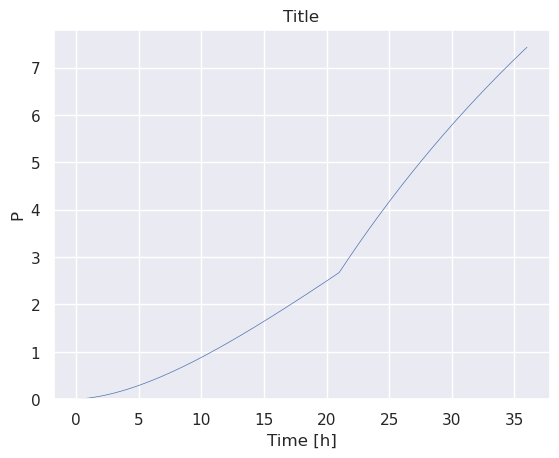

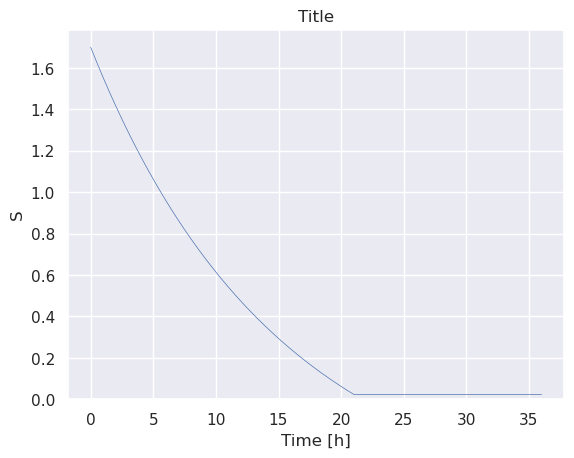

In [52]:
# Initial values
G_0 = 0         # Glucose (substrate)
V_0 = 0.5       # Volume
X_0 = 3.04      # Biomass
P_0 = 0         # Product (plasmid DNA)
S_0 = 1.7       # Sulfate
s_ini= [G_0, V_0, X_0, P_0, S_0]

r = sp.integrate.solve_ivp(growth_and_starvation_phase, t_span=[0, 36], y0=s_ini, t_eval=[36], dense_output=True, max_step=0.005)
t = np.linspace(0, 36, (36+1)*50) # (times[1]+1)*20 = Resolution

dat= pd.DataFrame(data={    'Time [h]'  : t, 
                                'V'     : r.sol(t)[1],
                                'X'     : r.sol(t)[2],
                                'P'     : r.sol(t)[3],
                                'S'     : r.sol(t)[4]})

sulfate_not_used = dat["S"].iloc[-1]
print("Sulfate that was not used:  ", sulfate_not_used)
print("Very low amount is left and therefore it supports the calculated optimal switch time.")

sns.lineplot(data=dat,x="Time [h]", y="V",linewidth=0.5,
).set(title="Title", ylim=(0, dat["V"].max()*1.05))
plt.show()

sns.lineplot(data=dat,x="Time [h]", y="X",linewidth=0.5,
).set(title="Title", ylim=(0, dat["X"].max()*1.05))
plt.show()

sns.lineplot(data=dat,x="Time [h]", y="P",linewidth=0.5,
).set(title="Title", ylim=(0, dat["P"].max()*1.05))
plt.show()

sns.lineplot(data=dat,x="Time [h]", y="S",linewidth=0.5,
).set(title="Title", ylim=(0, dat["S"].max()*1.05))
plt.show()